In [42]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import poisson, norm
from scipy.optimize import minimize_scalar

In [43]:
def q_simple_count(mu, n_obs, sig, bkg, debug=False):
    """
    Compute test statistic q for a single-bin experiment
    mu: the assumed signal strength
    n_obs: number of observed events
    sig: expected number of signal events
    bkg: expected number of bkg events
    """
    mu_opt = (n_obs-bkg)/sig # Would normally be a fit but easy in this case
    L_opt = poisson_likelihood(n_obs, mu_opt, sig, bkg)
    L_this_mu = poisson_likelihood(n_obs, mu, sig, bkg)
    _lambda = L_this_mu / L_opt
    q = -2*np.log(_lambda)
    if debug:
        if isinstance(mu, np.ndarray):
            print(f'{L_opt=}')
            print(f'{L_this_mu=}')
            print(f'{mu=}')
            print(f'{q=}')
            for _mu in mu: q_simple_count(_mu, n_obs, sig, bkg, debug)
        else:
            print(f'{mu=:.2f}, {mu_opt=:.2f}, {L_opt=:.5f}, {L_this_mu=:.5f}, lambda={_lambda:.5f}, {q=:.5f}')
    return q

def q_asimov(mu, mu_true, sig, bkg):
    n_true = mu_true * sig + bkg
    L_asimov = poisson_likelihood(n_true, mu_true, sig, bkg)
    L_this_mu = poisson_likelihood(n_true, mu, sig, bkg)
    _lambda = L_this_mu / L_asimov
    q = -2*np.log(_lambda)
    return q

def sigma_squared_asimov(mu, mu_true, sig, bkg):
    return mu**2 / q_asimov(mu, mu_true, sig, bkg)

def manual_poisson_likelihood(n_obs, mu, sig, bkg):
    n_exp = mu*sig+bkg
    return n_exp**n_obs / math.factorial(n_obs) * np.exp(-n_exp)

def poisson_likelihood(n_obs, mu, sig, bkg):
    return poisson.pmf(n_obs, mu*sig+bkg)

def solve_polynomial(polynomial_fit, y_value):
    the_fit = polynomial_fit.copy()
    the_fit[-1] -= y_value
    return np.roots(the_fit)

def solve_1par(fn, target):
    def fn_to_minimize(par):
        return (fn(par) - target)**2
    result = minimize_scalar(fn_to_minimize)
    return result.x

def solve_1par_manual(fn, target, init_par=1., gamma=0.05, debug=False):
    """Simple gradient descent single parameter minimizer"""
    par = init_par

    def fn_to_minimize(par):
        return (fn(par) - target)**2

    i = 0
    while fn_to_minimize(par) > 0.0005:
        curr_value = fn_to_minimize(par)
        curr_derivative = (fn_to_minimize(par+0.001) - curr_value)/0.001
        if debug:
            print(f'{i=}, {par=}, {curr_value=}, {curr_derivative=}, abs(target-curr_value)={abs(target-curr_value)}')
        i += 1
        curr_value = fn_to_minimize(par)
        curr_derivative = (fn_to_minimize(par+0.001) - curr_value)/0.001
        par -= gamma * curr_derivative
        if i == 10000: raise Exception('Too many minimizer calls')
    return par


For low statistics, the chi2 (parabolic) assumption of q doesn't hold:

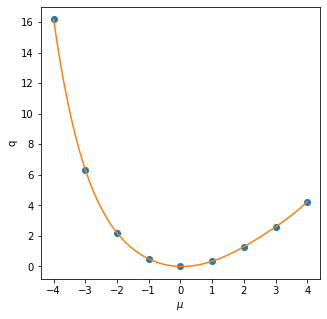

In [3]:
fig = plt.Figure(facecolor='white', figsize=(5,5))
ax = fig.gca()
mu = np.linspace(-4, 4, 9, dtype=np.int64)

q = q_simple_count(mu, n_obs=10, sig=2, bkg=10)
ax.plot(mu, q, 'o')

# Also plot a fit
mu_for_fit = np.linspace(min(mu), max(mu), 100)
y_fit = np.polyval(np.polyfit(mu, q, 6), mu_for_fit)
ax.plot(mu_for_fit, y_fit)
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'q')
fig

For high statistics q(mu) is parabolic:

In [83]:
def high_statistics_counting_experiment(n_obs, sig, bkg, alpha=0.025):
    fig = plt.Figure(facecolor='white', figsize=(5,5))
    ax = fig.gca()
    mu = np.linspace(-4, 4, 9, dtype=np.int64)

    mu_opt = float(n_obs-bkg)/sig

    q = q_simple_count(mu, n_obs, sig, bkg)
    ax.plot(mu, q, 'o')

    # Also plot a fit
    mu_for_fit = np.linspace(min(mu), max(mu), 100)
    quadratic_fit = np.polyfit(mu, q, 2)
    q_fit = np.polyval(quadratic_fit, mu_for_fit)
    ax.plot(mu_for_fit, q_fit)

    def calc_p_value(mu):
        return 1.-norm.cdf(np.sqrt(q_simple_count(mu, n_obs, sig, bkg)))

    mu_pvalue = solve_1par(calc_p_value, alpha)
    sigma_squared = sigma_squared_asimov(mu_pvalue, 0., sig, bkg)
    # sigma_squared = bkg / sig**2
    mu_cl95 = mu_opt + np.sqrt(sigma_squared) * norm.ppf(1-alpha)
    print(
        f'{mu_opt=:.4f}, {mu_pvalue=:.4f},'
        f' p_mu_pvalue={calc_p_value(mu_pvalue):.4f}, {sigma_squared=:.4f}, {mu_cl95=:.4f}'
        f', q(mu_cl95)={np.polyval(quadratic_fit, mu_cl95)}'
        )

    ax.plot([mu_cl95, mu_cl95], [0., max(q)], '--')
    ax.text(
        0.99, .99, f'$\\mu < {mu_cl95:.4f}$ (95% CL)',
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes
        )
    ax.set_xlabel(r'$\mu$')
    ax.set_ylabel(r'q')
    return fig

mu_opt=0.0000, mu_pvalue=0.9864, p_mu_pvalue=0.0250, sigma_squared=0.2533, mu_cl95=0.9864, q(mu_cl95)=3.2570810772088437


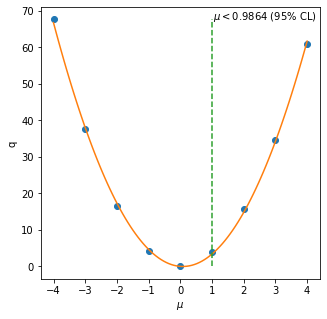

In [84]:
high_statistics_counting_experiment(n_obs=10000, sig=200, bkg=10000)

Corresponding combine output:<br>
Observed Limit: r < 0.9873<br>
Expected  2.5%: r < 0.5327<br>
Expected 16.0%: r < 0.7107<br>
Expected 50.0%: r < 0.9883<br>
Expected 84.0%: r < 1.3743<br>
Expected 97.5%: r < 1.8267

mu_opt=0.5000, mu_pvalue=-0.4785, p_mu_pvalue=0.0250, sigma_squared=0.2484, mu_cl95=1.4768, q(mu_cl95)=2.9630129292524194


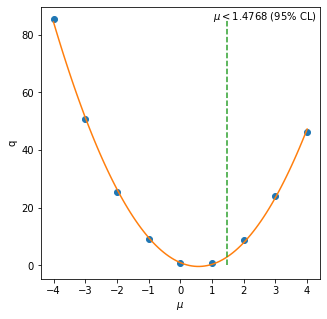

In [90]:
high_statistics_counting_experiment(n_obs=10100, sig=200, bkg=10000, alpha=0.025)

Corresponding combine output:<br>
Observed Limit: r < 1.3749<br>
Expected  2.5%: r < 0.5327<br>
Expected 16.0%: r < 0.7107<br>
Expected 50.0%: r < 0.9883<br>
Expected 84.0%: r < 1.3743<br>
Expected 97.5%: r < 1.8267

mu_opt=0.5000, mu_pvalue=-2.5941, p_mu_pvalue=0.0250, sigma_squared=2.4913, mu_cl95=3.5936, q(mu_cl95)=3.810804434446166


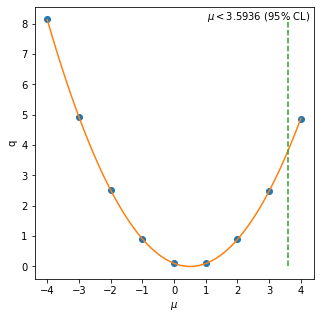

In [89]:
high_statistics_counting_experiment(n_obs=100100, sig=200, bkg=100000, alpha=0.025)

In [183]:
q_asimov(1., 0., sig, bkg)

3.9474540764349513

In [184]:
sigma_squared_asimov(1., 0., sig, bkg)

0.2533278362805239

Based on second derivates (https://arxiv.org/pdf/1007.1727.pdf , Eq.27)

In [185]:
sigma = bkg / sig**2
sigma

0.25

In [26]:
np.sqrt(sigma_squared_asimov(1.13766, 0., sig, bkg)) * norm.ppf(1-.025)

0.9873727736091173

In [27]:
def fn_to_solve(mu):
    return 2.*(1.-norm.cdf(np.sqrt(q_simple_count(mu, n_obs, sig, bkg))))

mu_cl= solve_1par(fn_to_solve, 0.025, init_par=.5)


In [68]:
print(norm.ppf(1-0.05))
print(norm.ppf(1-0.025))

1.6448536269514722
1.959963984540054
